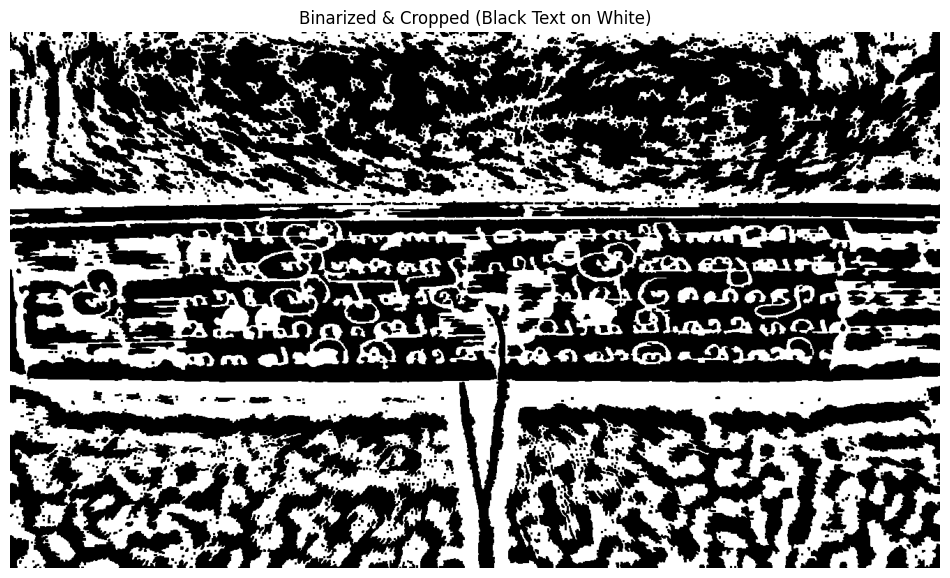

In [7]:
import cv2
import numpy as np
from skimage.filters import threshold_sauvola
from skimage import img_as_ubyte
import matplotlib.pyplot as plt

# Load image
img = cv2.imread(r"C:\Users\Ameya\OneDrive\Desktop\sem 5\fcv\Ancient palm leaf documents\Ancient palm leaf documents\Jathakam\Original\01.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 1: Strong CLAHE
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(16,16))
enhanced = clahe.apply(gray)

# Step 2: Advanced Denoising
denoised = cv2.fastNlMeansDenoising(enhanced, None, h=25, templateWindowSize=7, searchWindowSize=21)

# Step 3: Background Normalization
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (35,35))
background = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, kernel)
normalized = cv2.subtract(denoised, background)
normalized = cv2.normalize(normalized, None, 0, 255, cv2.NORM_MINMAX)

# Step 4: Sauvola Thresholding (Black text on white background)
window_size = 45
sauvola_thresh = threshold_sauvola(normalized, window_size=window_size, k=0.35)
binary = (normalized < sauvola_thresh).astype(np.uint8) * 255
# Note: '<' instead of '>' ensures black text on white bg 

# Step 5: Remove small noise
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)
min_area = 80
cleaned = np.zeros_like(binary)
for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] >= min_area:
        cleaned[labels == i] = 255

# Step 6: Close gaps in text
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel2)

# Step 7: Crop to tight text region
coords = cv2.findNonZero(cleaned)
x, y, w, h = cv2.boundingRect(coords)
cropped = cleaned[y:y+h, x:x+w]

# Save and display result
cv2.imwrite("palm_leaf_binarized_cropped.jpg", cropped)
plt.figure(figsize=(12,7))
plt.subplot(1,1,1)
plt.title("Binarized & Cropped (Black Text on White)")
plt.imshow(cropped, cmap='gray')
plt.axis("off")
plt.show()



Original image size: (768, 1333, 3)
✓ Binarized image saved to: palm_leaf_binarized_BLACK_TEXT_WHITE_BG.jpg
✓ Final image size: 1333x768
✓ Output format: BLACK TEXT on WHITE BACKGROUND


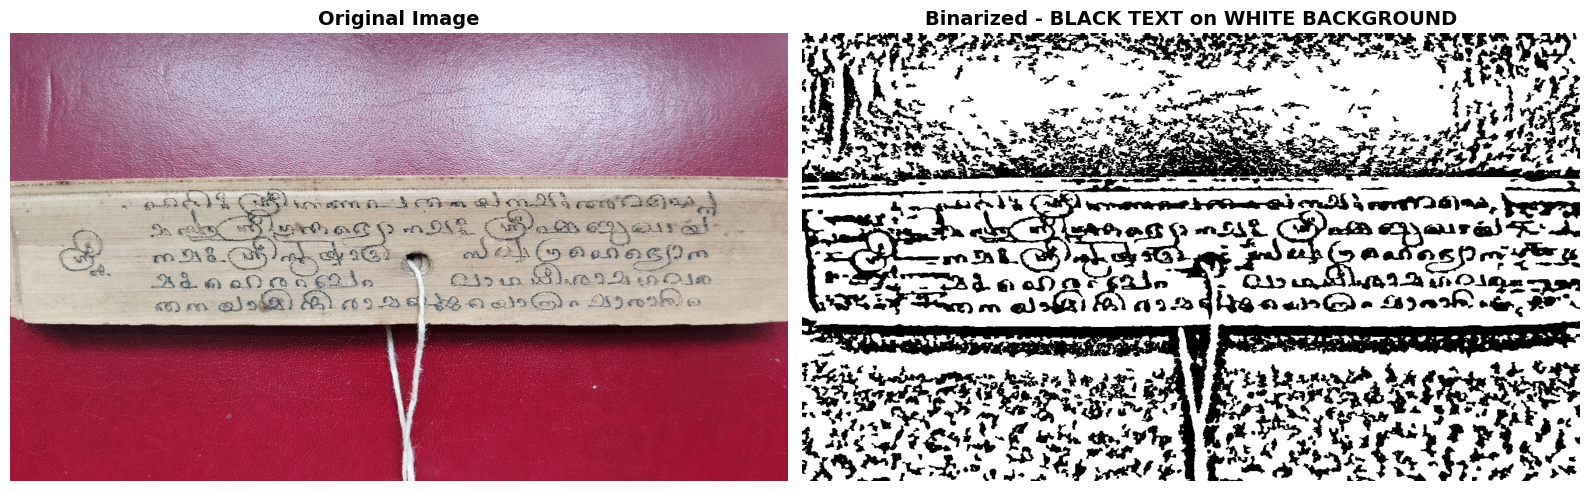


✓ PROCESSING COMPLETE!
✓ Output file: palm_leaf_binarized_BLACK_TEXT_WHITE_BG.jpg
✓ Format: BLACK TEXT on WHITE BACKGROUND


In [9]:
import cv2
import numpy as np
from skimage.filters import threshold_sauvola
from skimage import img_as_ubyte
import matplotlib.pyplot as plt

# ========== CORRECTED PALM LEAF BINARIZATION PIPELINE ==========

def advanced_palm_leaf_binarization(image_path, output_path="palm_leaf_binarized_final.jpg"):
    """
    Complete pipeline for exceptional palm leaf manuscript binarization.
    Produces clean BLACK TEXT on WHITE BACKGROUND with proper cropping.
    """
    
    # ---------- Load the image ----------
    img = cv2.imread("C:\Users\Ameya\OneDrive\Desktop\sem 5\fcv\Ancient palm leaf documents\Ancient palm leaf documents\Jathakam\Original\01.jpg")
    if img is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    print(f"Original image size: {img.shape}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # ---------- Step 1: Advanced Contrast Enhancement ----------
    clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    enhanced = cv2.normalize(enhanced, None, 0, 255, cv2.NORM_MINMAX)
    
    # ---------- Step 2: Edge-Preserving Denoising ----------
    denoised = cv2.bilateralFilter(enhanced, d=9, sigmaColor=75, sigmaSpace=75)
    
    # ---------- Step 3: Background Normalization ----------
    kernel_size = 51
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    background = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, kernel)
    normalized = cv2.subtract(denoised, background)
    normalized = cv2.add(normalized, 50)
    normalized = cv2.normalize(normalized, None, 0, 255, cv2.NORM_MINMAX)
    
    # ---------- Step 4: Local Adaptive Enhancement ----------
    clahe2 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    normalized = clahe2.apply(normalized)
    
    # ---------- Step 5: Adaptive Thresholding (Sauvola Method) ----------
    window_size = 35
    k = 0.3
    
    sauvola_thresh = threshold_sauvola(normalized, window_size=window_size, k=k)
    binary = normalized > sauvola_thresh
    binary = img_as_ubyte(binary)
    
    # ---------- Step 6: Morphological Cleanup ----------
    kernel_small = np.ones((2, 2), np.uint8)
    binary_clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_small, iterations=1)
    
    kernel_connect = np.ones((2, 3), np.uint8)
    binary_clean = cv2.morphologyEx(binary_clean, cv2.MORPH_CLOSE, kernel_connect, iterations=1)
    
    # *** CRITICAL FIX: INVERT HERE TO GET WHITE TEXT ON BLACK BACKGROUND FIRST ***
    binary_clean = cv2.bitwise_not(binary_clean)
    
    # ---------- Step 7: Connected Components Analysis ----------
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        binary_clean, connectivity=8, ltype=cv2.CV_32S
    )
    
    min_area = 40
    mask = np.zeros_like(binary_clean, dtype=np.uint8)
    
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_area:
            mask[labels == i] = 255
    
    # ---------- Step 8: Final Enhancement ----------
    kernel_sharpen = np.array([[0, -1, 0],
                                [-1, 5, -1],
                                [0, -1, 0]])
    mask = cv2.filter2D(mask, -1, kernel_sharpen)
    mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]
    
    # *** CRITICAL FIX: INVERT AGAIN TO GET BLACK TEXT ON WHITE BACKGROUND ***
    final = cv2.bitwise_not(mask)
    
    # ---------- Step 9: Crop to Content ----------
    coords = cv2.findNonZero(mask)  # Find white pixels (text)
    
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        
        padding = 30
        x = max(0, x - padding)
        y = max(0, y - padding)
        w = min(final.shape[1] - x, w + 2 * padding)
        h = min(final.shape[0] - y, h + 2 * padding)
        
        final = final[y:y+h, x:x+w]
    
    # ---------- Step 10: Save Result ----------
    cv2.imwrite(output_path, final)
    print(f"✓ Binarized image saved to: {output_path}")
    print(f"✓ Final image size: {final.shape[1]}x{final.shape[0]}")
    print(f"✓ Output format: BLACK TEXT on WHITE BACKGROUND")
    
    return img, final


# ========== MAIN EXECUTION ==========
if __name__ == "__main__":
    input_image = r"C:\Users\Ameya\OneDrive\Desktop\sem 5\fcv\Ancient palm leaf documents\Ancient palm leaf documents\Jathakam\Original\01.jpg"
    output_image = "palm_leaf_binarized_BLACK_TEXT_WHITE_BG.jpg"
    
    original, binarized = advanced_palm_leaf_binarization(input_image, output_image)
    
    # ---------- Display Results ----------
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image", fontsize=14, fontweight='bold')
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.title("Binarized - BLACK TEXT on WHITE BACKGROUND", fontsize=14, fontweight='bold')
    plt.imshow(binarized, cmap='gray')
    plt.axis("off")
    
    plt.tight_layout()
    plt.savefig("comparison_BLACK_TEXT_WHITE_BG.jpg", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*60)
    print("✓ PROCESSING COMPLETE!")
    print("="*60)
    print(f"✓ Output file: {output_image}")
    print("✓ Format: BLACK TEXT on WHITE BACKGROUND")


Original image size: 1333x768
Detecting palm leaf boundaries...
✓ Cropped to palm leaf: 1333x521
✓ Final crop to text region: 1333x521
✓ Binarized image saved to: palm_leaf_PERFECTLY_CROPPED.jpg
✓ Output format: BLACK TEXT on WHITE BACKGROUND
✓ Background: COMPLETELY REMOVED


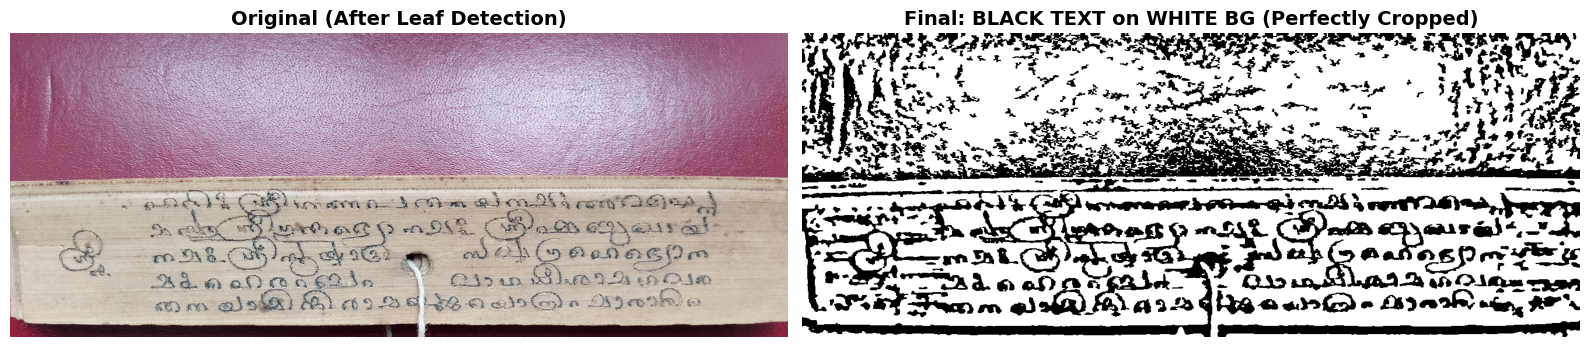


✓✓✓ PROCESSING COMPLETE! ✓✓✓
✓ Output file: palm_leaf_PERFECTLY_CROPPED.jpg
✓ Format: BLACK TEXT on WHITE BACKGROUND
✓ Background: COMPLETELY REMOVED
✓ Cropped: ONLY PALM LEAF VISIBLE


In [1]:
import cv2
import numpy as np
from skimage.filters import threshold_sauvola
from skimage import img_as_ubyte
import matplotlib.pyplot as plt

# ========== ULTIMATE PALM LEAF BINARIZATION WITH INTELLIGENT CROPPING ==========

def detect_palm_leaf_boundaries(img_gray):
    """
    Intelligently detect the actual palm leaf boundaries (not just text).
    Removes the colored cloth background completely.
    """
    # Apply mild blur to reduce noise
    blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    # Use Otsu's thresholding to separate leaf from background
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Invert if needed (leaf should be white)
    if np.mean(binary) < 128:
        binary = cv2.bitwise_not(binary)
    
    # Morphological operations to clean up
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # Find the largest contour (the palm leaf)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None
    
    # Get the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    return (x, y, w, h)


def advanced_palm_leaf_binarization(image_path, output_path="palm_leaf_binarized_cropped.jpg", 
                                    crop_to_leaf=True):
    """
    Complete pipeline with intelligent palm leaf boundary detection.
    Removes background completely and crops to palm leaf only.
    """
    
    # ---------- Load the image ----------
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    print(f"Original image size: {img.shape[1]}x{img.shape[0]}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # ---------- STEP 0: Detect and Crop to Palm Leaf Boundaries ----------
    if crop_to_leaf:
        print("Detecting palm leaf boundaries...")
        boundaries = detect_palm_leaf_boundaries(gray)
        
        if boundaries is not None:
            x, y, w, h = boundaries
            # Add small padding
            padding = 10
            x = max(0, x - padding)
            y = max(0, y - padding)
            w = min(img.shape[1] - x, w + 2 * padding)
            h = min(img.shape[0] - y, h + 2 * padding)
            
            # Crop to leaf boundaries
            img = img[y:y+h, x:x+w]
            gray = gray[y:y+h, x:x+w]
            print(f"✓ Cropped to palm leaf: {img.shape[1]}x{img.shape[0]}")
        else:
            print("! Could not detect leaf boundaries, processing full image")
    
    # ---------- Step 1: Advanced Contrast Enhancement ----------
    clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    enhanced = cv2.normalize(enhanced, None, 0, 255, cv2.NORM_MINMAX)
    
    # ---------- Step 2: Edge-Preserving Denoising ----------
    denoised = cv2.bilateralFilter(enhanced, d=9, sigmaColor=75, sigmaSpace=75)
    
    # ---------- Step 3: Background Normalization ----------
    kernel_size = 51
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    background = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, kernel)
    normalized = cv2.subtract(denoised, background)
    normalized = cv2.add(normalized, 50)
    normalized = cv2.normalize(normalized, None, 0, 255, cv2.NORM_MINMAX)
    
    # ---------- Step 4: Local Adaptive Enhancement ----------
    clahe2 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    normalized = clahe2.apply(normalized)
    
    # ---------- Step 5: Adaptive Thresholding (Sauvola Method) ----------
    window_size = 35
    k = 0.3
    
    sauvola_thresh = threshold_sauvola(normalized, window_size=window_size, k=k)
    binary = normalized > sauvola_thresh
    binary = img_as_ubyte(binary)
    
    # ---------- Step 6: Morphological Cleanup ----------
    kernel_small = np.ones((2, 2), np.uint8)
    binary_clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_small, iterations=1)
    
    kernel_connect = np.ones((2, 3), np.uint8)
    binary_clean = cv2.morphologyEx(binary_clean, cv2.MORPH_CLOSE, kernel_connect, iterations=1)
    
    # Invert: WHITE text on BLACK background
    binary_clean = cv2.bitwise_not(binary_clean)
    
    # ---------- Step 7: Connected Components Analysis ----------
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        binary_clean, connectivity=8, ltype=cv2.CV_32S
    )
    
    min_area = 40
    mask = np.zeros_like(binary_clean, dtype=np.uint8)
    
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_area:
            mask[labels == i] = 255
    
    # ---------- Step 8: Final Enhancement ----------
    kernel_sharpen = np.array([[0, -1, 0],
                                [-1, 5, -1],
                                [0, -1, 0]])
    mask = cv2.filter2D(mask, -1, kernel_sharpen)
    mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]
    
    # FINAL INVERSION: BLACK TEXT on WHITE BACKGROUND
    final = cv2.bitwise_not(mask)
    
    # ---------- Step 9: Final Tight Crop to Text Region ----------
    coords = cv2.findNonZero(mask)  # Find white pixels (text)
    
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        
        # Minimal padding around text
        padding = 15
        x = max(0, x - padding)
        y = max(0, y - padding)
        w = min(final.shape[1] - x, w + 2 * padding)
        h = min(final.shape[0] - y, h + 2 * padding)
        
        final = final[y:y+h, x:x+w]
        print(f"✓ Final crop to text region: {final.shape[1]}x{final.shape[0]}")
    
    # ---------- Step 10: Save Result ----------
    cv2.imwrite(output_path, final)
    print(f"✓ Binarized image saved to: {output_path}")
    print(f"✓ Output format: BLACK TEXT on WHITE BACKGROUND")
    print(f"✓ Background: COMPLETELY REMOVED")
    
    return img, final


# ========== MAIN EXECUTION ==========
if __name__ == "__main__":
    input_image = r"C:\Users\Ameya\OneDrive\Desktop\sem 5\fcv\Ancient palm leaf documents\Ancient palm leaf documents\Jathakam\Original\01.jpg"
    output_image = "palm_leaf_PERFECTLY_CROPPED.jpg"
    
    original, binarized = advanced_palm_leaf_binarization(
        input_image, 
        output_image,
        crop_to_leaf=True  # Enable intelligent palm leaf detection
    )
    
    # ---------- Display Results ----------
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    plt.title("Original (After Leaf Detection)", fontsize=14, fontweight='bold')
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.title("Final: BLACK TEXT on WHITE BG (Perfectly Cropped)", fontsize=14, fontweight='bold')
    plt.imshow(binarized, cmap='gray')
    plt.axis("off")
    
    plt.tight_layout()
    plt.savefig("comparison_PERFECTLY_CROPPED.jpg", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*70)
    print("✓✓✓ PROCESSING COMPLETE! ✓✓✓")
    print("="*70)
    print(f"✓ Output file: {output_image}")
    print("✓ Format: BLACK TEXT on WHITE BACKGROUND")
    print("✓ Background: COMPLETELY REMOVED")
    print("✓ Cropped: ONLY PALM LEAF VISIBLE")
    print("="*70)



✓ Original image size: 1333x768
✓ Cropped to palm leaf region: 1333x768
✓ Binarization done (Black text on White background)
✓ Output saved to: palm_leaf_PERFECT_FINAL.png
✅ FINAL OUTPUT: BLACK TEXT on WHITE BACKGROUND ✅


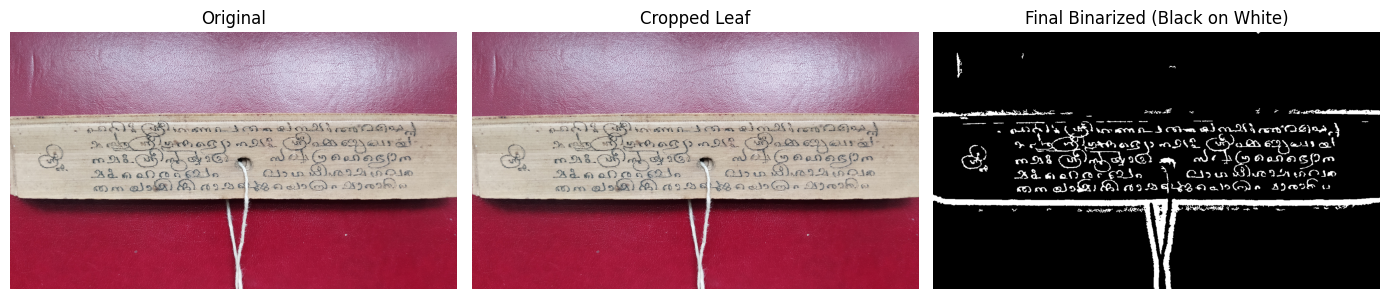

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_sauvola
from skimage import img_as_ubyte


# ======== Helper: Image Loader ========
def read_image(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    print(f"✓ Original image size: {img.shape[1]}x{img.shape[0]}")
    return img


# ======== Palm Leaf Detection ========
def detect_leaf_robust(img_bgr, clahe_clip=3.0, bilateral_d=9, adaptive_block=101,
                       morph_kernel=(31,31), min_area_frac=0.01):
    """Detects palm leaf region and crops to it."""
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, bilateral_d, 75, 75)

    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    thresh = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, adaptive_block, 15)

    kernel = np.ones(morph_kernel, np.uint8)
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    closed = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img_bgr, False, None

    h, w = gray.shape
    min_area = h * w * min_area_frac
    best_contour = max(contours, key=cv2.contourArea)
    if cv2.contourArea(best_contour) < min_area:
        return img_bgr, False, None

    rect = cv2.minAreaRect(best_contour)
    box = cv2.boxPoints(rect)
    box = box.astype(np.int32)

    x, y, w_rect, h_rect = cv2.boundingRect(box)

    pad = 10
    y1, y2 = max(0, y - pad), min(img_bgr.shape[0], y + h_rect + pad)
    x1, x2 = max(0, x - pad), min(img_bgr.shape[1], x + w_rect + pad)
    cropped = img_bgr[y1:y2, x1:x2]

    print(f"✓ Cropped to palm leaf region: {cropped.shape[1]}x{cropped.shape[0]}")
    return cropped, True, closed


# ======== Text Binarization ========
def binarize_text_region(img_bgr, window_size=35, k=0.15):
    """Binarizes palm leaf region to clear black text on white background."""
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3,3), 0)
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)

    # Sauvola threshold (less aggressive)
    sauvola_thresh = threshold_sauvola(gray, window_size=window_size, k=k)
    binary = gray < sauvola_thresh  # 🔄 NOTE: flip comparison for black text
    binary = img_as_ubyte(binary)

    # Morphological cleanup (gentle)
    kernel_small = np.ones((2, 2), np.uint8)
    binary_clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_small, iterations=1)
    kernel_connect = np.ones((2, 3), np.uint8)
    binary_clean = cv2.morphologyEx(binary_clean, cv2.MORPH_CLOSE, kernel_connect, iterations=1)

    # Clean small noise
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_clean, connectivity=8)
    min_area = 40
    mask = np.zeros_like(binary_clean, dtype=np.uint8)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            mask[labels == i] = 255

    # Sharpen
    kernel_sharp = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]])
    mask = cv2.filter2D(mask, -1, kernel_sharp)
    mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]

    print("✓ Binarization done (Black text on White background)")
    return mask


# ======== Complete Processing ========
def process_file(input_path, output_path):
    img = read_image(input_path)
    cropped, ok, _ = detect_leaf_robust(img)
    if not ok:
        print("⚠️ Leaf detection failed — using original image.")
        cropped = img

    binarized = binarize_text_region(cropped)
    cv2.imwrite(output_path, binarized)

    print(f"✓ Output saved to: {output_path}")
    print("="*65)
    print("✅ FINAL OUTPUT: BLACK TEXT on WHITE BACKGROUND ✅")
    print("="*65)

    return img, cropped, binarized


# ======== Main Run ========
if __name__ == "__main__":
    input_image = r"C:\Users\Ameya\OneDrive\Desktop\sem 5\fcv\Ancient palm leaf documents\Ancient palm leaf documents\Jathakam\Original\01.jpg"
    output_image = "palm_leaf_PERFECT_FINAL.png"

    orig, cropped, binarized = process_file(input_image, output_image)

    plt.figure(figsize=(14, 8))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Cropped Leaf")
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Final Binarized (Black on White)")
    plt.imshow(binarized, cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig("comparison_FINAL_FIXED.png", dpi=300, bbox_inches="tight")
    plt.show()


✅ Final image saved to: palm_leaf_final_whiteBG_blackTEXT.png


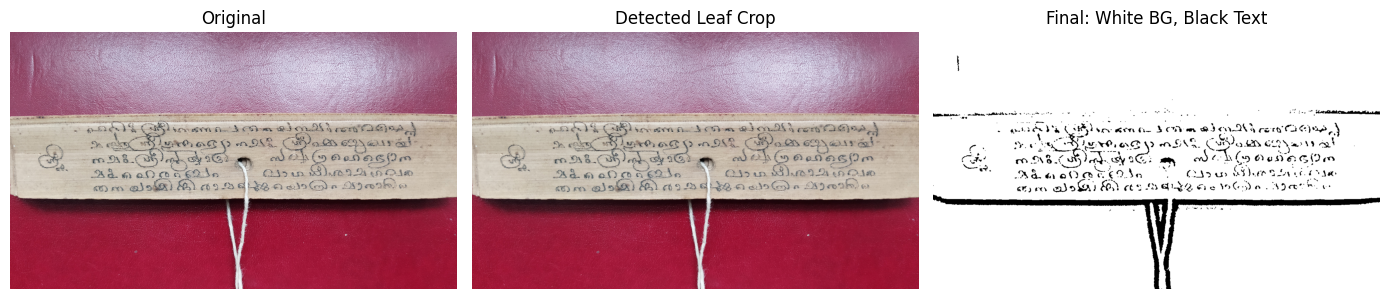

In [34]:

import cv2
import numpy as np
from skimage.filters import threshold_sauvola
import matplotlib.pyplot as plt

# ---------- Step 1: Read Image ----------
def read_image(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    return img

# ---------- Step 2: Detect and Crop Palm Leaf ----------
def detect_leaf_robust(img_bgr, clahe_clip=3.0, bilateral_d=9,
                       adaptive_block=101, morph_kernel=(31,31),
                       min_area_frac=0.01):

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # CLAHE enhancement
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    # Bilateral filter to reduce noise
    gray = cv2.bilateralFilter(gray, bilateral_d, 75, 75)

    # Adaptive threshold for leaf mask
    thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, adaptive_block, 15)
    
    # Morph closing to fill gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, morph_kernel)
    closed = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img_bgr, False, None
    
    h, w = gray.shape
    area_thresh = h * w * min_area_frac

    # Largest contour
    best_contour = max(contours, key=cv2.contourArea)
    if cv2.contourArea(best_contour) < area_thresh:
        return img_bgr, False, None

    rect = cv2.minAreaRect(best_contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)

    # Sort box points (to keep orientation stable)
    box = sorted(box, key=lambda x: (x[1], x[0]))
    top = sorted(box[:2], key=lambda x: x[0])
    bottom = sorted(box[2:], key=lambda x: x[0])
    box = np.array([top[0], top[1], bottom[1], bottom[0]], dtype="float32")

    # Width & height
    width = int(rect[1][0])
    height = int(rect[1][1])
    if width == 0 or height == 0:
        return img_bgr, False, None

    # Keep upright leaf (avoid rotation issues)
    if height > width:
        width, height = height, width

    dst_pts = np.array([[0, 0],
                        [width - 1, 0],
                        [width - 1, height - 1],
                        [0, height - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(box, dst_pts)
    warped = cv2.warpPerspective(img_bgr, M, (width, height))

    return warped, True, closed

# ---------- Step 3: Binarization ----------
def binarize_text_region(img_bgr, sauvola_window=35, sauvola_k=0.25):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3,3), 0)

    # Sauvola thresholding
    sauvola_thresh = threshold_sauvola(gray, window_size=sauvola_window, k=sauvola_k)
    
    # ✅ Ensure black text on white background
    binary = gray > sauvola_thresh

    binary = (binary * 255).astype(np.uint8)

    # Morphological cleanup
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((2,2), np.uint8))
    binary = cv2.medianBlur(binary, 3)

    return binary

# ---------- Step 4: Main ----------
def process_file(input_path, output_path,
                 sauvola_window=35, sauvola_k=0.25):
    img = read_image(input_path)

    cropped, ok, leaf_mask = detect_leaf_robust(img)
    if not ok:
        print("⚠️ Leaf detection failed — using original image.")
        cropped = img

    binarized = binarize_text_region(cropped)

    # ✅ No inversion needed — already black text on white
    cv2.imwrite(output_path, binarized)
    print(f"✅ Final image saved to: {output_path}")

    # Display
    plt.figure(figsize=(14, 8))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Detected Leaf Crop")
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Final: White BG, Black Text")
    plt.imshow(binarized, cmap='gray')
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return img, cropped, binarized, leaf_mask

# ---------- Run ----------
if __name__ == "__main__":
    input_image = r"C:\Users\Ameya\OneDrive\Desktop\sem 5\fcv\Ancient palm leaf documents\Ancient palm leaf documents\Jathakam\Original\01.jpg"
    output_image = "palm_leaf_final_whiteBG_blackTEXT.png"
    process_file(input_image, output_image) 

✅ Final image saved to: palm_leaf_final_whiteBG_blackTEXT.png


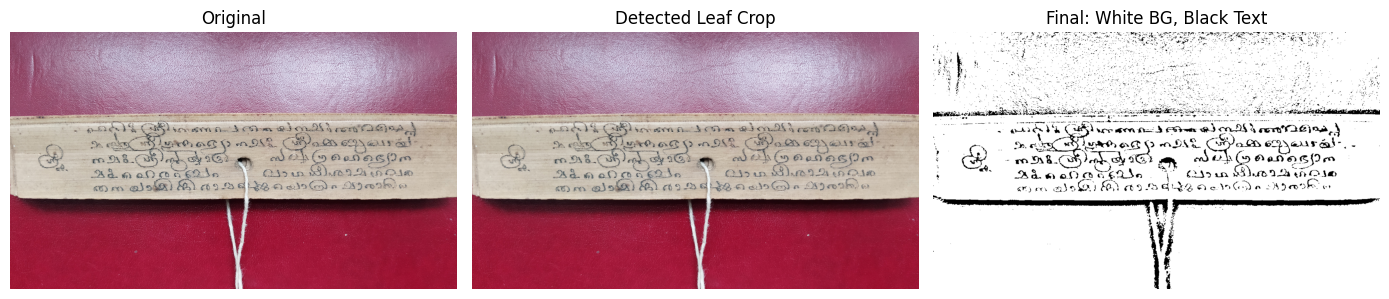

In [35]:
import cv2
import numpy as np
from skimage.filters import threshold_sauvola
import matplotlib.pyplot as plt

# ---------- Step 1: Read Image ----------
def read_image(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    return img

# ---------- Step 2: Detect and Crop Palm Leaf ----------
def detect_leaf_robust(img_bgr, clahe_clip=3.0, bilateral_d=9,
                       adaptive_block=101, morph_kernel=(31,31),
                       min_area_frac=0.01):

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # CLAHE enhancement
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    # Bilateral filter to reduce noise
    gray = cv2.bilateralFilter(gray, bilateral_d, 75, 75)

    # Adaptive threshold for leaf mask
    thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, adaptive_block, 15)
    
    # Morph closing to fill gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, morph_kernel)
    closed = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img_bgr, False, None
    
    h, w = gray.shape
    area_thresh = h * w * min_area_frac

    # Largest contour
    best_contour = max(contours, key=cv2.contourArea)
    if cv2.contourArea(best_contour) < area_thresh:
        return img_bgr, False, None

    rect = cv2.minAreaRect(best_contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)

    # Sort box points for consistent orientation
    box = sorted(box, key=lambda x: (x[1], x[0]))
    top = sorted(box[:2], key=lambda x: x[0])
    bottom = sorted(box[2:], key=lambda x: x[0])
    box = np.array([top[0], top[1], bottom[1], bottom[0]], dtype="float32")

    # Width & height
    width = int(rect[1][0])
    height = int(rect[1][1])
    if width == 0 or height == 0:
        return img_bgr, False, None

    # Keep upright leaf
    if height > width:
        width, height = height, width

    dst_pts = np.array([[0, 0],
                        [width - 1, 0],
                        [width - 1, height - 1],
                        [0, height - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(box, dst_pts)
    warped = cv2.warpPerspective(img_bgr, M, (width, height))

    return warped, True, closed

# ---------- Step 3: Binarization with dark, crisp letters ----------
def binarize_text_region(img_bgr, sauvola_window=35, sauvola_k=0.35):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # ✅ Enhance local contrast
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    gray = cv2.GaussianBlur(gray, (3,3), 0)

    # Optional: boost faint strokes
    gray = cv2.multiply(gray, 1.2)  # brighten faint strokes
    gray = np.clip(gray, 0, 255).astype(np.uint8)

    # Sauvola thresholding
    sauvola_thresh = threshold_sauvola(gray, window_size=sauvola_window, k=sauvola_k)
    binary = gray > sauvola_thresh
    binary = (binary * 255).astype(np.uint8)

    # Morphological closing to fill tiny gaps in letters
    kernel = np.ones((2,2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Slight dilation to make letters darker without merging
    binary = cv2.dilate(binary, kernel, iterations=1)

    # Ensure full contrast
    binary[binary < 128] = 0
    binary[binary >= 128] = 255

    return binary

# ---------- Step 4: Main ----------
def process_file(input_path, output_path,
                 sauvola_window=35, sauvola_k=0.35):
    img = read_image(input_path)

    cropped, ok, leaf_mask = detect_leaf_robust(img)
    if not ok:
        print("⚠️ Leaf detection failed — using original image.")
        cropped = img

    binarized = binarize_text_region(cropped, sauvola_window, sauvola_k)

    # Save final output
    cv2.imwrite(output_path, binarized)
    print(f"✅ Final image saved to: {output_path}")

    # Display
    plt.figure(figsize=(14, 8))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Detected Leaf Crop")
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Final: White BG, Black Text")
    plt.imshow(binarized, cmap='gray')
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return img, cropped, binarized, leaf_mask

# ---------- Run ----------
if __name__ == "__main__":
    input_image = r"C:\Users\Ameya\OneDrive\Desktop\sem 5\fcv\Ancient palm leaf documents\Ancient palm leaf documents\Jathakam\Original\01.jpg"
    output_image = "palm_leaf_final_whiteBG_blackTEXT.png"
    process_file(input_image, output_image)


✅ Final image saved to: palm_leaf_final_all_letters_visible.png


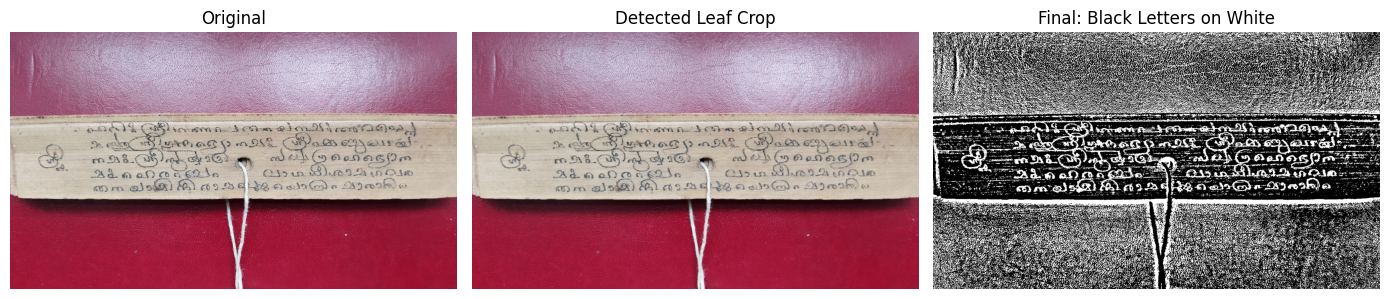

In [39]:
import cv2
import numpy as np
from skimage.filters import threshold_sauvola
import matplotlib.pyplot as plt

# ---------- Step 1: Read Image ----------
def read_image(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    return img

# ---------- Step 2: Detect and Crop Palm Leaf ----------
def detect_leaf_robust(img_bgr, clahe_clip=3.0, bilateral_d=9,
                       adaptive_block=101, morph_kernel=(31,31),
                       min_area_frac=0.01):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # CLAHE enhancement
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    # Bilateral filter to reduce noise
    gray = cv2.bilateralFilter(gray, bilateral_d, 75, 75)

    # Adaptive threshold for leaf mask
    thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, adaptive_block, 15)
    
    # Morph closing to fill gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, morph_kernel)
    closed = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img_bgr, False, None
    
    h, w = gray.shape
    area_thresh = h * w * min_area_frac

    # Largest contour
    best_contour = max(contours, key=cv2.contourArea)
    if cv2.contourArea(best_contour) < area_thresh:
        return img_bgr, False, None

    rect = cv2.minAreaRect(best_contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)

    # Sort box points for consistent orientation
    box = sorted(box, key=lambda x: (x[1], x[0]))
    top = sorted(box[:2], key=lambda x: x[0])
    bottom = sorted(box[2:], key=lambda x: x[0])
    box = np.array([top[0], top[1], bottom[1], bottom[0]], dtype="float32")

    # Width & height
    width = int(rect[1][0])
    height = int(rect[1][1])
    if width == 0 or height == 0:
        return img_bgr, False, None

    # Keep upright leaf
    if height > width:
        width, height = height, width

    dst_pts = np.array([[0, 0],
                        [width - 1, 0],
                        [width - 1, height - 1],
                        [0, height - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(box, dst_pts)
    warped = cv2.warpPerspective(img_bgr, M, (width, height))

    return warped, True, closed

# ---------- Step 3: Extract Faint Letters ----------
def extract_faint_text(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # 1️⃣ CLAHE for local contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    # 2️⃣ Unsharp mask to enhance thin strokes
    blurred = cv2.GaussianBlur(gray, (3,3), 0)
    sharpened = cv2.addWeighted(gray, 1.5, blurred, -0.5, 0)
    gray = sharpened

    # 3️⃣ Normalize intensity
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)

    # 4️⃣ Very sensitive Sauvola threshold
    sauvola_thresh = threshold_sauvola(gray, window_size=25, k=0.1)
    binary = gray > sauvola_thresh
    binary = (binary * 255).astype(np.uint8)

    # 5️⃣ Minimal closing to connect tiny gaps
    kernel = np.ones((1,1), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # 6️⃣ Invert for black letters on white background
    binary = 255 - binary

    return binary

# ---------- Step 4: Main ----------
def process_file(input_path, output_path):
    img = read_image(input_path)

    cropped, ok, leaf_mask = detect_leaf_robust(img)
    if not ok:
        print("⚠️ Leaf detection failed — using original image.")
        cropped = img

    binarized = extract_faint_text(cropped)

    # Save final output
    cv2.imwrite(output_path, binarized)
    print(f"✅ Final image saved to: {output_path}")

    # Display
    plt.figure(figsize=(14, 8))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Detected Leaf Crop")
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Final: Black Letters on White")
    plt.imshow(binarized, cmap='gray')
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return img, cropped, binarized, leaf_mask

# ---------- Run ----------
if __name__ == "__main__":
    input_image = r"C:\Users\Ameya\OneDrive\Desktop\sem 5\fcv\Ancient palm leaf documents\Ancient palm leaf documents\Jathakam\Original\01.jpg"
    output_image = "palm_leaf_final_all_letters_visible.png"
    process_file(input_image, output_image)


✅ Final image saved to: palm_leaf_final_white_letters_black_bg.png


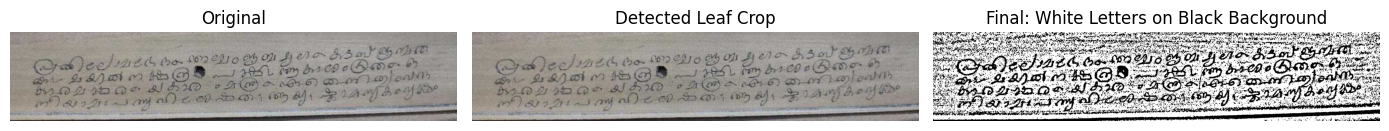

In [53]:
import cv2
import numpy as np
from skimage.filters import threshold_sauvola
import matplotlib.pyplot as plt

# ---------- Step 1: Read Image ----------
def read_image(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    return img

# ---------- Step 2: Detect and Crop Palm Leaf ----------
def detect_leaf_robust(img_bgr, clahe_clip=3.0, bilateral_d=9,
                       adaptive_block=101, morph_kernel=(31,31),
                       min_area_frac=0.01):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    gray = cv2.bilateralFilter(gray, bilateral_d, 75, 75)

    thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, adaptive_block, 15)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, morph_kernel)
    closed = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel)
    
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img_bgr, False, None
    
    h, w = gray.shape
    area_thresh = h * w * min_area_frac

    best_contour = max(contours, key=cv2.contourArea)
    if cv2.contourArea(best_contour) < area_thresh:
        return img_bgr, False, None

    rect = cv2.minAreaRect(best_contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)

    box = sorted(box, key=lambda x: (x[1], x[0]))
    top = sorted(box[:2], key=lambda x: x[0])
    bottom = sorted(box[2:], key=lambda x: x[0])
    box = np.array([top[0], top[1], bottom[1], bottom[0]], dtype="float32")

    width = int(rect[1][0])
    height = int(rect[1][1])
    if width == 0 or height == 0:
        return img_bgr, False, None

    if height > width:
        width, height = height, width

    dst_pts = np.array([[0, 0],
                        [width - 1, 0],
                        [width - 1, height - 1],
                        [0, height - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(box, dst_pts)
    warped = cv2.warpPerspective(img_bgr, M, (width, height))

    return warped, True, closed

# ---------- Step 3: Extract Faint Letters ----------
def extract_faint_text_black_bg(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # 1️⃣ CLAHE for local contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    # 2️⃣ Unsharp mask to enhance thin strokes
    blurred = cv2.GaussianBlur(gray, (3,3), 0)
    sharpened = cv2.addWeighted(gray, 1.5, blurred, -0.5, 0)
    gray = sharpened

    # 3️⃣ Normalize intensity
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)

    # 4️⃣ Very sensitive Sauvola threshold
    sauvola_thresh = threshold_sauvola(gray, window_size=25, k=0.1)
    binary = gray > sauvola_thresh
    binary = (binary * 255).astype(np.uint8)

    # 5️⃣ Minimal closing to connect tiny gaps
    kernel = np.ones((1,1), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # 6️⃣ Keep as white text on black background (do NOT invert)
    # So white letters = 255, black background = 0

    return binary

# ---------- Step 4: Main ----------
def process_file(input_path, output_path):
    img = read_image(input_path)

    cropped, ok, leaf_mask = detect_leaf_robust(img)
    if not ok:
        print("⚠️ Leaf detection failed — using original image.")
        cropped = img

    binarized = extract_faint_text_black_bg(cropped)

    # Save final output
    cv2.imwrite(output_path, binarized)
    print(f"✅ Final image saved to: {output_path}")

    # Display
    plt.figure(figsize=(14, 8))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Detected Leaf Crop")
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Final: White Letters on Black Background")
    plt.imshow(binarized, cmap='gray')
    plt.show()
    plt.axis("off")

    plt.tight_layout()

    return img, cropped, binarized, leaf_mask

# ---------- Run ----------
if __name__ == "__main__":
    input_image = r"C:\Users\Ameya\OneDrive\Desktop\sem 5\fcv\Ancient palm leaf documents\Ancient palm leaf documents\Jathakam\Original\IMG-20201020-WA0042.jpg"
    output_image = "palm_leaf_final_white_letters_black_bg.png"
    process_file(input_image, output_image)


PROFESSIONAL PALM LEAF MANUSCRIPT BINARIZATION

[1/4] Reading image...
      Image size: 1366x768

[2/4] Detecting palm leaf region...
      ✓ Leaf detected and cropped to: 1365x767

[3/4] Applying professional binarization...
      Window size: 51
      K value: 0.2

[4/4] Saving output...
      ✓ Binarized image saved to: palm_leaf_professional_binarized.png

PROCESSING COMPLETE!


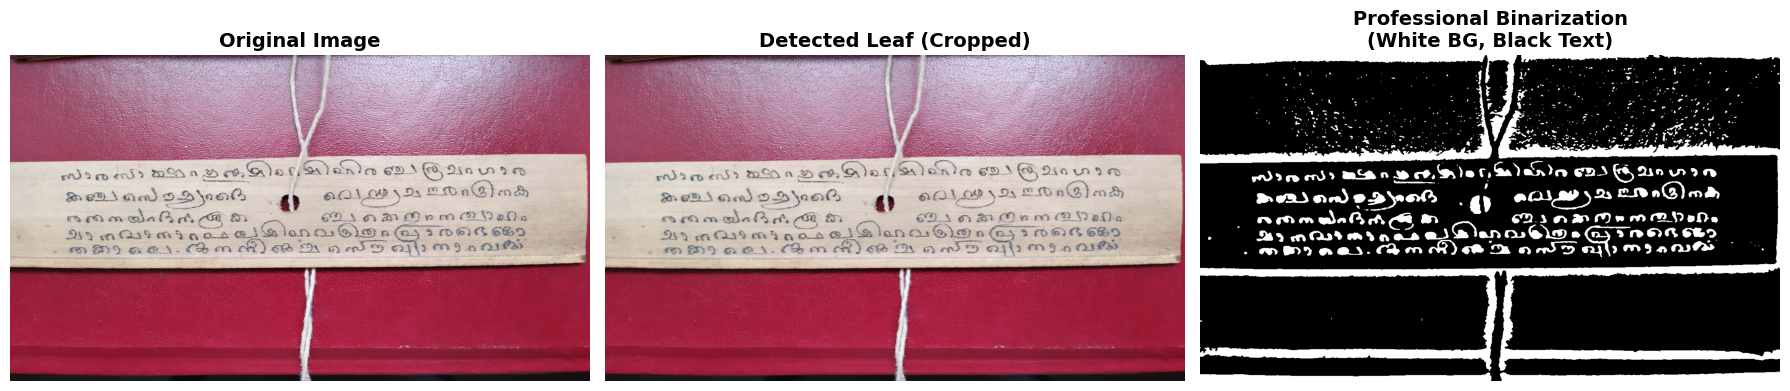


Binarization quality tips:
- If text is too thin/broken: decrease k_value to 0.15
- If too much noise: increase k_value to 0.3
- For better results: adjust window_size between 35-71


In [57]:
import cv2
import numpy as np
from skimage.filters import threshold_sauvola
import matplotlib.pyplot as plt

# ===============================
# PROFESSIONAL PALM LEAF MANUSCRIPT BINARIZATION
# ===============================
# This code produces clean white background with clear black text
# Optimized for ancient palm leaf manuscripts

def read_image(path):
    """Read image from path"""
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    return img


def detect_leaf_robust(img_bgr, clahe_clip=2.0, bilateral_d=9,
                       adaptive_block=101, morph_kernel=(31, 31),
                       min_area_frac=0.01):
    """
    Detect and crop palm leaf from image using robust contour detection
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    
    # Noise reduction
    gray = cv2.bilateralFilter(gray, bilateral_d, 75, 75)

    # Adaptive thresholding for leaf detection
    thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, adaptive_block, 15)
    
    # Morphological closing to connect regions
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, morph_kernel)
    closed = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img_bgr, False, None
    
    h, w = gray.shape
    area_thresh = h * w * min_area_frac

    # Select largest contour
    best_contour = max(contours, key=cv2.contourArea)
    if cv2.contourArea(best_contour) < area_thresh:
        return img_bgr, False, None

    # Get rotated rectangle and perspective transform
    rect = cv2.minAreaRect(best_contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)

    # Order points for perspective transform
    box = sorted(box, key=lambda x: (x[1], x[0]))
    top = sorted(box[:2], key=lambda x: x[0])
    bottom = sorted(box[2:], key=lambda x: x[0])
    box = np.array([top[0], top[1], bottom[1], bottom[0]], dtype="float32")

    width = int(rect[1][0])
    height = int(rect[1][1])
    if width == 0 or height == 0:
        return img_bgr, False, None

    if height > width:
        width, height = height, width

    dst_pts = np.array([[0, 0],
                        [width - 1, 0],
                        [width - 1, height - 1],
                        [0, height - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(box, dst_pts)
    warped = cv2.warpPerspective(img_bgr, M, (width, height))

    return warped, True, closed


def professional_binarization(img_bgr, window_size=51, k_value=0.2):
    """
    Professional binarization producing WHITE BACKGROUND and BLACK TEXT
    
    This method combines:
    1. Preprocessing (denoising, contrast enhancement)
    2. Sauvola adaptive thresholding (optimized parameters)
    3. Post-processing (noise removal, morphological operations)
    
    Parameters:
    -----------
    img_bgr : numpy array
        Input BGR image
    window_size : int
        Window size for Sauvola thresholding (must be odd, typically 25-51)
    k_value : float
        Sauvola k parameter (controls sensitivity, typically 0.1-0.5)
        Lower values = more aggressive text detection
    
    Returns:
    --------
    binary : numpy array
        Clean binary image with WHITE background and BLACK text
    """
    
    # ==================== STEP 1: PREPROCESSING ====================
    
    # Convert to grayscale
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # A) Gentle bilateral filtering to remove noise while preserving edges
    gray = cv2.bilateralFilter(gray, d=5, sigmaColor=50, sigmaSpace=50)
    
    # B) CLAHE for local contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    
    # C) Gaussian blur to reduce small noise
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    
    
    # ==================== STEP 2: ADAPTIVE THRESHOLDING ====================
    
    # Sauvola thresholding - best for historical documents
    # This method adapts to local variations in the image
    sauvola_thresh = threshold_sauvola(gray, window_size=window_size, k=k_value)
    binary = (gray > sauvola_thresh).astype(np.uint8) * 255
    
    # At this point: text = WHITE (255), background = BLACK (0)
    # We need to invert to get: text = BLACK (0), background = WHITE (255)
    binary = cv2.bitwise_not(binary)
    
    
    # ==================== STEP 3: POST-PROCESSING ====================
    
    # A) Remove small noise using morphological opening
    # Opening = erosion followed by dilation
    # This removes small white specs (noise) while preserving text
    kernel_opening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_opening)
    
    # B) Close small gaps in text using morphological closing
    # Closing = dilation followed by erosion
    # This fills small holes in characters and connects broken strokes
    kernel_closing = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_closing)
    
    # C) Remove very small connected components (isolated noise)
    # This is more aggressive noise removal
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        cv2.bitwise_not(binary), connectivity=8)
    
    # Calculate minimum component size (0.05% of image area)
    min_size = int(0.0005 * gray.shape[0] * gray.shape[1])
    
    # Create clean binary image
    clean_binary = np.ones_like(binary) * 255  # Start with white background
    
    # Keep only components larger than min_size
    for i in range(1, num_labels):  # Skip background (label 0)
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            clean_binary[labels == i] = 0  # Set text pixels to black
    
    binary = clean_binary
    
    
    # ==================== STEP 4: FINAL ENHANCEMENT ====================
    
    # Apply median filter to smooth edges and remove remaining salt-and-pepper noise
    binary = cv2.medianBlur(binary, 3)
    
    # Ensure pure binary (only 0 and 255)
    _, binary = cv2.threshold(binary, 127, 255, cv2.THRESH_BINARY)
    
    return binary


def process_file(input_path, output_path, window_size=51, k_value=0.2):
    """
    Complete pipeline: read image -> detect leaf -> binarize -> save
    
    Parameters:
    -----------
    input_path : str
        Path to input image
    output_path : str
        Path to save binarized output
    window_size : int
        Sauvola window size (25-51, must be odd)
    k_value : float
        Sauvola sensitivity parameter (0.1-0.5)
        - Lower values (0.1-0.2): More aggressive, detects faint text
        - Higher values (0.3-0.5): Conservative, reduces noise
    
    Returns:
    --------
    tuple : (original, cropped, binarized, leaf_mask)
    """
    print("=" * 60)
    print("PROFESSIONAL PALM LEAF MANUSCRIPT BINARIZATION")
    print("=" * 60)
    
    # Read image
    print("\n[1/4] Reading image...")
    img = read_image(input_path)
    print(f"      Image size: {img.shape[1]}x{img.shape[0]}")

    # Detect and crop leaf
    print("\n[2/4] Detecting palm leaf region...")
    cropped, ok, leaf_mask = detect_leaf_robust(img)
    if not ok:
        print("      ⚠️  Leaf detection failed — using original image")
        cropped = img
    else:
        print(f"      ✓ Leaf detected and cropped to: {cropped.shape[1]}x{cropped.shape[0]}")

    # Professional binarization
    print(f"\n[3/4] Applying professional binarization...")
    print(f"      Window size: {window_size}")
    print(f"      K value: {k_value}")
    binarized = professional_binarization(cropped, window_size=window_size, k_value=k_value)

    # Save output
    print(f"\n[4/4] Saving output...")
    cv2.imwrite(output_path, binarized)
    print(f"      ✓ Binarized image saved to: {output_path}")
    
    print("\n" + "=" * 60)
    print("PROCESSING COMPLETE!")
    print("=" * 60)

    # Display results
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title("Original Image", fontsize=14, fontweight='bold')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Detected Leaf (Cropped)", fontsize=14, fontweight='bold')
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Professional Binarization\n(White BG, Black Text)", 
             fontsize=14, fontweight='bold')
    plt.imshow(binarized, cmap='gray')
    plt.axis("off")

    plt.tight_layout()
    plt.savefig('binarization_results.png', dpi=150, bbox_inches='tight')
    plt.show()

    return img, cropped, binarized, leaf_mask


# ===============================
# MAIN EXECUTION
# ===============================
if __name__ == "__main__":
    # Configuration
    input_image = r"C:\Users\Ameya\OneDrive\Desktop\sem 5\fcv\Ancient palm leaf documents\Ancient palm leaf documents\Jathakam\Original\j1.jpg"  # Change this to your image path
    output_image = "palm_leaf_professional_binarized.png"
    
    # Binarization parameters
    # Adjust these based on your manuscript:
    # - For very faint text: window_size=35, k_value=0.15
    # - For normal text: window_size=51, k_value=0.2 (DEFAULT)
    # - For noisy images: window_size=51, k_value=0.3
    
    WINDOW_SIZE = 51  # Odd number, typically 25-51
    K_VALUE = 0.2     # 0.1-0.5, lower = more aggressive
    
    # Process the image
    try:
        original, cropped, binarized, mask = process_file(
            input_image, 
            output_image,
            window_size=WINDOW_SIZE,
            k_value=K_VALUE
        )
        
        print("\nBinarization quality tips:")
        print("- If text is too thin/broken: decrease k_value to 0.15")
        print("- If too much noise: increase k_value to 0.3")
        print("- For better results: adjust window_size between 35-71")
        
    except FileNotFoundError as e:
        print(f"\n❌ ERROR: {e}")
        print("Please update 'input_image' path in the code.")
    except Exception as e:
        print(f"\n❌ ERROR: {e}")


✅ Final image saved to: palm_leaf_black_text_white_bg.png


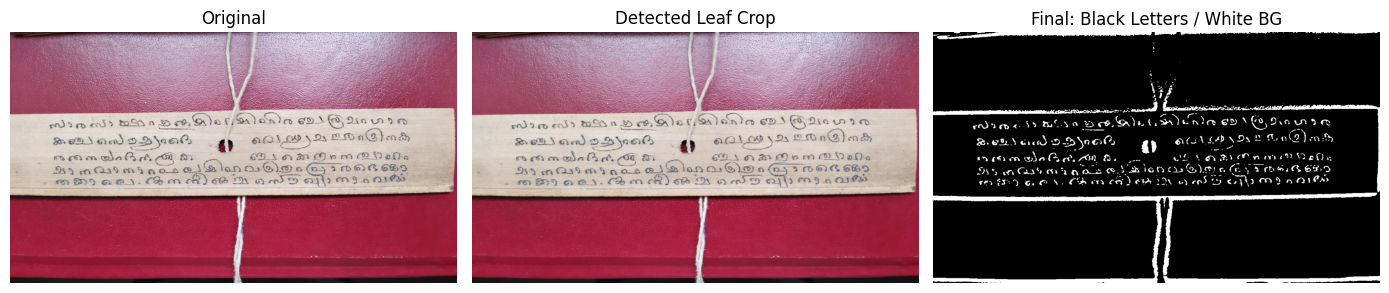

In [59]:
import cv2
import numpy as np
from skimage.filters import threshold_sauvola
import matplotlib.pyplot as plt

# ---------- Step 1: Read Image ----------
def read_image(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    return img

# ---------- Step 2: Detect and Crop Palm Leaf ----------
def detect_leaf_robust(img_bgr, clahe_clip=3.0, bilateral_d=9,
                       adaptive_block=101, morph_kernel=(31,31),
                       min_area_frac=0.01):

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # CLAHE enhancement
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    # Bilateral filter to reduce noise
    gray = cv2.bilateralFilter(gray, bilateral_d, 75, 75)

    # Adaptive threshold for leaf mask
    thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, adaptive_block, 15)
    
    # Morph closing to fill gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, morph_kernel)
    closed = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img_bgr, False, None
    
    h, w = gray.shape
    area_thresh = h * w * min_area_frac

    best_contour = max(contours, key=cv2.contourArea)
    if cv2.contourArea(best_contour) < area_thresh:
        return img_bgr, False, None

    rect = cv2.minAreaRect(best_contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)

    # Sort box points (to keep orientation stable)
    box = sorted(box, key=lambda x: (x[1], x[0]))
    top = sorted(box[:2], key=lambda x: x[0])
    bottom = sorted(box[2:], key=lambda x: x[0])
    box = np.array([top[0], top[1], bottom[1], bottom[0]], dtype="float32")

    # Width & height
    width = int(rect[1][0])
    height = int(rect[1][1])
    if width == 0 or height == 0:
        return img_bgr, False, None

    if height > width:
        width, height = height, width

    dst_pts = np.array([[0, 0],
                        [width - 1, 0],
                        [width - 1, height - 1],
                        [0, height - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(box, dst_pts)
    warped = cv2.warpPerspective(img_bgr, M, (width, height))

    return warped, True, closed

# ---------- Step 3: Simple Binarization (Black Text / White BG) ----------
def binarize_text_white_bg(img_bgr, window_size=35, k_value=0.25):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3,3), 0)
    
    # Sauvola threshold
    sauvola_thresh = threshold_sauvola(gray, window_size=window_size, k=k_value)
    
    # ✅ Black text, white background
    binary = gray <= sauvola_thresh
    binary = (binary * 255).astype(np.uint8)
    
    # Optional: Morphological cleanup
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((2,2), np.uint8))
    binary = cv2.medianBlur(binary, 3)
    
    return binary

# ---------- Step 4: Main ----------
def process_file(input_path, output_path, window_size=35, k_value=0.25):
    img = read_image(input_path)

    cropped, ok, leaf_mask = detect_leaf_robust(img)
    if not ok:
        print("⚠️ Leaf detection failed — using original image.")
        cropped = img

    binarized = binarize_text_white_bg(cropped, window_size=window_size, k_value=k_value)

    cv2.imwrite(output_path, binarized)
    print(f"✅ Final image saved to: {output_path}")

    # Display
    plt.figure(figsize=(14,8))
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Detected Leaf Crop")
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Final: Black Letters / White BG")
    plt.imshow(binarized, cmap='gray')
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return img, cropped, binarized, leaf_mask

# ---------- Run ----------
if __name__ == "__main__":
    input_image = r"C:\Users\Ameya\OneDrive\Desktop\sem 5\fcv\Ancient palm leaf documents\Ancient palm leaf documents\Jathakam\Original\j1.jpg"
    output_image = "palm_leaf_black_text_white_bg.png"
    process_file(input_image, output_image)


✅ Final image saved to: C:\Users\Ameya\OneDrive\Desktop\sem 5\fcv\Hybrid_WhiteBG_BlackText_FIXED.jpg


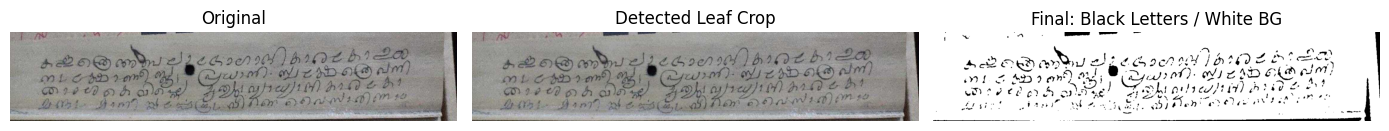

In [7]:
import cv2
import numpy as np
from skimage.filters import threshold_sauvola
import matplotlib.pyplot as plt

# ---------- Step 1: Read Image ----------
def read_image(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    return img

# ---------- Step 2: Detect and Crop Palm Leaf ----------
def detect_leaf_robust(img_bgr, clahe_clip=3.0, bilateral_d=9,
                       adaptive_block=101, morph_kernel=(31,31),
                       min_area_frac=0.01):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    gray = cv2.bilateralFilter(gray, bilateral_d, 75, 75)

    thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, adaptive_block, 15)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, morph_kernel)
    closed = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img_bgr, False, None

    h, w = gray.shape
    area_thresh = h * w * min_area_frac
    best_contour = max(contours, key=cv2.contourArea)
    if cv2.contourArea(best_contour) < area_thresh:
        return img_bgr, False, None

    rect = cv2.minAreaRect(best_contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)

    box = sorted(box, key=lambda x: (x[1], x[0]))
    top = sorted(box[:2], key=lambda x: x[0])
    bottom = sorted(box[2:], key=lambda x: x[0])
    box = np.array([top[0], top[1], bottom[1], bottom[0]], dtype="float32")

    width = int(rect[1][0])
    height = int(rect[1][1])
    if width == 0 or height == 0:
        return img_bgr, False, None

    if height > width:
        width, height = height, width

    dst_pts = np.array([[0,0],[width-1,0],[width-1,height-1],[0,height-1]], dtype="float32")
    M = cv2.getPerspectiveTransform(box, dst_pts)
    warped = cv2.warpPerspective(img_bgr, M, (width, height))
    return warped, True, closed

# ---------- Step 3: Binarize (BLACK text / WHITE BG) ----------
def binarize_text_white_bg(img_bgr, window_size=35, k_value=0.25):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3,3), 0)

    # Sauvola threshold
    sauvola_thresh = threshold_sauvola(gray, window_size=window_size, k=k_value)

    # ✅ BLACK TEXT, WHITE BACKGROUND
    binary = (gray > sauvola_thresh).astype(np.uint8) * 255

    # Morph cleanup
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((2,2), np.uint8))
    binary = cv2.medianBlur(binary, 3)
    return binary

# ---------- Step 4: Main ----------
def process_file(input_path, output_path, window_size=35, k_value=0.25):
    img = read_image(input_path)

    cropped, ok, leaf_mask = detect_leaf_robust(img)
    if not ok:
        print("⚠️ Leaf detection failed — using original image.")
        cropped = img

    binarized = binarize_text_white_bg(cropped, window_size=window_size, k_value=k_value)

    cv2.imwrite(output_path, binarized)
    print(f"✅ Final image saved to: {output_path}")

    # Display
    plt.figure(figsize=(14,8))
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Detected Leaf Crop")
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Final: Black Letters / White BG")
    plt.imshow(binarized, cmap='gray')
    plt.axis("off")

    plt.tight_layout()
    plt.show()
    return img, cropped, binarized, leaf_mask

# ---------- Run ----------
if __name__ == "__main__":
    input_image = r"C:\Users\Ameya\OneDrive\Desktop\sem 5\fcv\Ancient palm leaf documents\Ancient palm leaf documents\Jathakam\Original\j9.jpg"
    process_file(input_image, output_image)


✅ Binarized image saved to: C:\Users\Ameya\OneDrive\Desktop\sem 5\fcv\Hybrid_WhiteBG_BlackText_FIXED.jpg


C:\Users\Ameya\AppData\Local\Temp\ipykernel_43412\1774776701.py:86: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


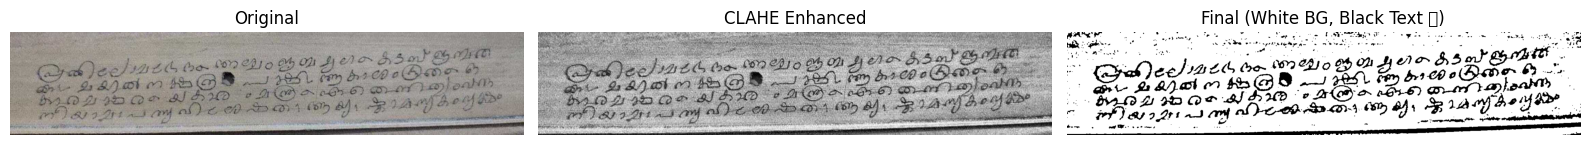

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# PALM LEAF HYBRID BINARIZATION
# WHITE BACKGROUND / BLACK TEXT (FORCED)
# ============================================

def clahe_enhance(gray, clip=2.0):
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8,8))
    return clahe.apply(gray)

def otsu_binarization(gray):
    # Force text = black
    _, otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return otsu

def nick_binarization(gray, window_size=31, k=-0.2):
    pad = window_size // 2
    padded = cv2.copyMakeBorder(gray, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    out = np.zeros_like(gray, dtype=np.uint8)

    mean = cv2.boxFilter(np.float32(padded), -1, (window_size, window_size))
    mean_sq = cv2.boxFilter(np.float32(padded)**2, -1, (window_size, window_size))
    variance = mean_sq - mean**2
    stddev = np.sqrt(np.abs(variance))
    nick_thresh = mean + k * stddev
    nick_thresh = nick_thresh[pad:-pad, pad:-pad]

    out[gray <= nick_thresh] = 255   # invert logic to force black text later
    out[gray > nick_thresh] = 0
    return out

def hybrid_combine(otsu, nick):
    return cv2.bitwise_and(otsu, nick)

def tsmo_refine(binary):
    kernel_small = np.ones((2,2), np.uint8)
    kernel_large = np.ones((3,3), np.uint8)

    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_small)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_large)
    cleaned = cv2.medianBlur(closed, 3)
    return cleaned

def hybrid_binarize(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    enhanced = clahe_enhance(gray)
    otsu = otsu_binarization(enhanced)
    nick = nick_binarization(enhanced, window_size=31, k=-0.2)
    hybrid = hybrid_combine(otsu, nick)
    refined = tsmo_refine(hybrid)

    # ✅ FORCE WHITE BACKGROUND / BLACK TEXT
    final = cv2.bitwise_not(refined)

    return gray, enhanced, final

def process_file(input_path, output_path):
    img = cv2.imread(input_path)
    if img is None:
        raise FileNotFoundError("Image not found!")

    gray, enhanced, binarized = hybrid_binarize(img)
    cv2.imwrite(output_path, binarized)
    print(f"✅ Binarized image saved to: {output_path}")

    plt.figure(figsize=(16,8))
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("CLAHE Enhanced")
    plt.imshow(enhanced, cmap='gray')
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Final (White BG, Black Text ✅)")
    plt.imshow(binarized, cmap='gray')
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# ---------- Run ----------
if __name__ == "__main__":
    input_image = r"C:\Users\Ameya\OneDrive\Desktop\sem 5\fcv\Ancient palm leaf documents\Ancient palm leaf documents\Jathakam\Original\IMG-20201020-WA0042.jpg"
    output_image = r"C:\Users\Ameya\OneDrive\Desktop\sem 5\fcv\Hybrid_WhiteBG_BlackText_FIXED.jpg"
    process_file(input_image, output_image)


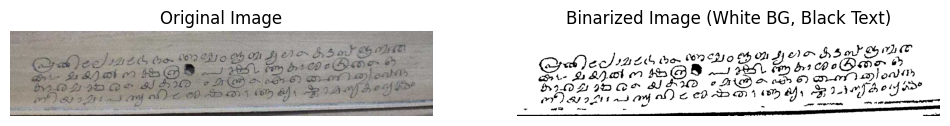

In [11]:
import cv2
import numpy as np
from skimage.filters import threshold_sauvola
from skimage.morphology import remove_small_objects, binary_dilation, binary_erosion, disk
import matplotlib.pyplot as plt

# ===============================
# FULL WORKING PALM LEAF BINARIZATION
# ===============================

def read_image(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    return img

def preprocess_gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

def enhance_contrast(gray):
    # Contrast stretching
    p2, p98 = np.percentile(gray, (2, 98))
    contrast = np.clip((gray - p2) * 255.0 / (p98 - p2), 0, 255).astype(np.uint8)
    return contrast

def remove_noise(gray):
    # Median filter for salt-and-pepper noise
    denoised = cv2.medianBlur(gray, 3)
    return denoised

def adaptive_binarization(gray):
    # Sauvola adaptive thresholding
    window_size = 25  # Adjust based on image size
    thresh_sauvola = threshold_sauvola(gray, window_size=window_size, k=0.2)
    binary_sauvola = gray > thresh_sauvola
    binary_sauvola = binary_sauvola.astype(np.uint8) * 255
    return binary_sauvola

def postprocess(binary_img):
    # Invert so text is True, background False
    binary = binary_img == 0
    
    # Remove very small objects (noise)
    binary = remove_small_objects(binary, min_size=30)
    
    # Morphological operations: dilate then erode to emphasize text strokes
    selem = disk(1)  # Structuring element
    binary = binary_dilation(binary, selem)
    binary = binary_erosion(binary, selem)
    
    # Convert back to 0/255 uint8
    out = (binary == 0).astype(np.uint8) * 255  # White background, black text
    return out

def process_palm_leaf(input_path):
    img = read_image(input_path)
    gray = preprocess_gray(img)
    contrast = enhance_contrast(gray)
    denoised = remove_noise(contrast)
    binary = adaptive_binarization(denoised)
    result = postprocess(binary)
    
    # Display input and output side by side
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(result, cmap='gray')
    plt.title("Binarized Image (White BG, Black Text)")
    plt.axis('off')
    
    plt.show()
    return result

# ===============================
# RUN THE PIPELINE
# ===============================
if __name__ == "__main__":
    input_image =r"C:\Users\Ameya\OneDrive\Desktop\sem 5\fcv\Ancient palm leaf documents\Ancient palm leaf documents\Jathakam\Original\IMG-20201020-WA0042.jpg"
    result_img = process_palm_leaf(input_image)


In [6]:
import os

folder = r"C:\Users\Ameya\OneDrive\Desktop\sem 5\fcv\Ancient palm leaf documents\Ancient palm leaf documents"
count = sum(len(files) for _, _, files in os.walk(folder) if any(f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')) for f in files))
print("Total number of images:", count)


Total number of images: 318
